<a href="https://colab.research.google.com/github/CryptoRobotFr/TrueStrategy/blob/main/Cross%20EMA%20%2B%20stoch%20RSI%231/Cross_EMA_%2B_stoch_RSI_TrueStrategy_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python-binance

In [ ]:
pip install ta

<h1>Import Dataset</h1>

In [3]:
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt

client = Client()

klinesT = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1HOUR, "01 january 2017")

df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

del df['ignore']
del df['close_time']
del df['quote_av']
del df['trades']
del df['tb_base_av']
del df['tb_quote_av']

df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
print(df)

                        open     high      low    close          volume
timestamp                                                              
2017-08-17 04:00:00   301.13   302.57   298.00   301.61    125.66877000
2017-08-17 05:00:00   301.61   303.28   300.00   303.10    377.67246000
2017-08-17 06:00:00   302.40   304.44   301.90   302.68    303.86672000
2017-08-17 07:00:00   302.68   307.96   302.60   307.96    754.74510000
2017-08-17 08:00:00   307.95   309.97   307.00   308.62    150.75029000
...                      ...      ...      ...      ...             ...
2021-08-08 06:00:00  3130.33  3184.87  3130.32  3167.07  57387.79317000
2021-08-08 07:00:00  3167.25  3187.00  3131.52  3137.84  47438.39619000
2021-08-08 08:00:00  3137.85  3156.00  3121.00  3124.12  25491.65035000
2021-08-08 09:00:00  3124.13  3160.00  3121.00  3139.64  21967.28302000
2021-08-08 10:00:00  3139.65  3151.66  3135.00  3135.00   4252.69024000

[34735 rows x 5 columns]


<h1>Backtest Execution</h1>

Create Indicators

In [4]:
#dfTest = df['2020-07-16':]
dfTest = df.copy()

# dfTest['histo_macd']=ta.trend.macd_diff(dfTest['close'], 26, 12, 9)
dfTest['EMA28']=ta.trend.ema_indicator(dfTest['close'], 28)
dfTest['EMA48']=ta.trend.ema_indicator(dfTest['close'], 48)
# dfTest['MACD']=ta.trend.macd(dfTest['close'], 26, 12, 9)
# dfTest['MACD_SIGNAL']=ta.trend.macd_signal(dfTest['close'], 26, 12, 9)
# dfTest['MACD_HISTO']= dfTest['MACD'] - dfTest['MACD_SIGNAL']
# dfTest['EMA8']=ta.trend.ema_indicator(dfTest['close'], 8)
# dfTest['EMA14']=ta.trend.ema_indicator(dfTest['close'], 14)
# dfTest['EMA50']=ta.trend.ema_indicator(dfTest['close'], 50)
dfTest['STOCH_RSI']=ta.momentum.stochrsi(dfTest['close'])
# dfTest['MEAN_STOCH_RSI'] = ta.trend.sma_indicator(dfTest['STOCH_RSI'], 3)
# dfTest['SIGNAL_MEAN_STOCH_RSI'] = ta.trend.sma_indicator(dfTest['MEAN_STOCH_RSI'], 3)
dfTest

,open,high,low,close,volume,EMA28,EMA48,STOCH_RSI
timestamp,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877000,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246000,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672000,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510000,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-08-08 06:00:00,3130.33,3184.87,3130.32,3167.07,57387.79317000,3059.181536,2992.780470,0.545060
2021-08-08 07:00:00,3167.25,3187.00,3131.52,3137.84,47438.39619000,3064.606258,2998.701267,0.169060
2021-08-08 08:00:00,3137.85,3156.00,3121.00,3124.12,25491.65035000,3068.710654,3003.820399,0.003400


Make backtest

Period : [2017-08-17 04:00:00] -> [2021-08-08 10:00:00]
Starting balance : 1000 $
Final balance : 138842.98 $
Performance vs US Dollar : 13784.3 %
Buy and Hold Performence : 939.42 %
Performance vs Buy and Hold : 1367.32 %
Number of negative trades :  158
Number of positive trades :  90
Average Positive Trades :  11.55 %
Average Negative Trades :  -2.5 %
Best trade +65.08 %, the  2018-01-11 14:00:00
Worst trade -9.9 %, the  2020-05-10 07:00:00
Worst drawBack -36.0 %
Total fee :  3476.97 $
PLOT


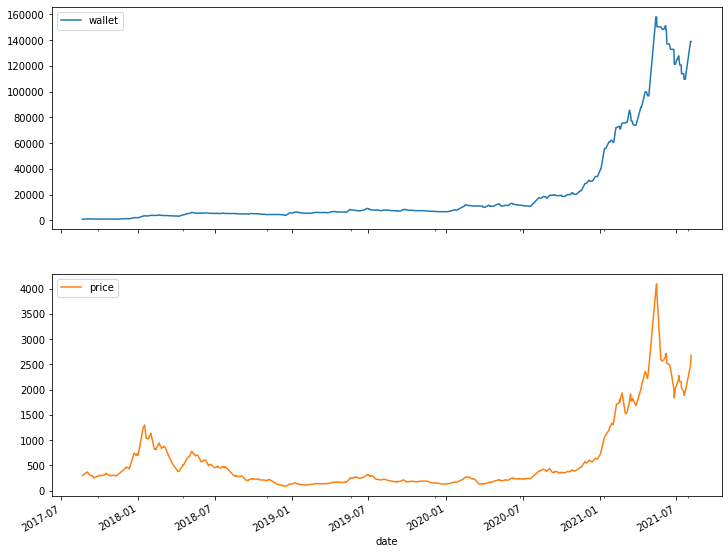

In [5]:
dt = None
dt = pd.DataFrame(columns = ['date','position', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
lastIndex = df.first_valid_index()
fee = 0.0007

for index, row in dfTest.iterrows():
  #Buy
  if row['EMA28'] > row['EMA48'] and row['STOCH_RSI'] < 0.8 and  usdt > 0:
    coin = usdt / row['close']
    frais = fee * coin
    coin = coin - frais
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet
    # print("Buy COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Buy",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Sell
  if row['EMA28'] < row['EMA48'] and row['STOCH_RSI'] > 0.2 and coin > 0:
    usdt = coin * row['close']
    frais = fee * usdt
    usdt = usdt - frais
    coin = 0
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at",df['close'][index],'$ the', index)
    myrow = {'date': index,'position': "Sell",'price': row['close'],'frais': frais,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  lastIndex = index

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")

dt[['wallet','price']].plot(subplots=True, figsize=(12,10))
print('PLOT')

<h1>Backtest Result</h1>